In [12]:
import numpy as np
import astra
import os
import imageio
import time
import matplotlib.pyplot as plt
import random

load data
0.254 sec elapsed
pre-process data
2.751 sec elapsed
load and pre-process data
42.831 sec elapsed
compute reconstruction:
running power iteration to determine step size
plugin initialized.
running 50 iterations of Accelerated Gradient plugin.
iteration 0 / 50 (251, 251, 251)
0  Objective Function  15136324.384529114
1  Objective Function  10120788.279877782
2  Objective Function  6900055.624028325
3  Objective Function  4847109.875736356
4  Objective Function  3629932.2544671297
5  Objective Function  2803442.600221753
6  Objective Function  2198740.337548375
7  Objective Function  1720312.1060552076
8  Objective Function  1339756.81224633
9  Objective Function  1050785.9521007836
iteration 10 / 50 (251, 251, 251)
10  Objective Function  822678.9983511269
11  Objective Function  648921.7788688019
12  Objective Function  522095.73399761505
13  Objective Function  422636.30599648505
14  Objective Function  348274.38256147504
15  Objective Function  293158.0219638422
16  Objecti

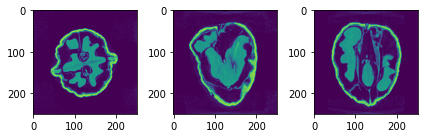

In [3]:
# Reconstruction Code for a given Walnut Case

# select the ID of the sample you want to reconstruct
walnut_id = 1
# select also the orbit you want to reconstruct the data from:
# 1 higher source position, 2 middle source position, 3 lower source position
orbit_id = 2
# define a sub-sampling factor in angular direction
# (all reference reconstructions are computed with full angular resolution)
angluar_sub_sampling = 10
# select of voxels per mm in one direction (higher = larger res)
# (all reference reconstructions are computed with 10)
voxel_per_mm = 5

# we enter here some intrinsic details of the dataset needed for our reconstruction scripts
# set the variable "data_path" to the path where the dataset is stored on your own workstation
data_path = '/media/pranjal/newdrive1/Walnuts/'
# set the variable "recon_path" to the path where you would like to store the
# reconstructions you compute
recon_path = '/media/pranjal/newdrive1/Walnut_recons/'

t = time.time();
print('load data', flush=True)

# we add the info about walnut and orbit ID
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections', 'tubeV{}'.format(orbit_id))
projs_name = 'scan_{:06}.tif'
dark_name = 'di000000.tif'
flat_name = ['io000000.tif', 'io000001.tif']
vecs_name = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# load the numpy array describing the scan geometry from file
vecs = np.loadtxt(os.path.join(data_path_full, vecs_name))
# get the positions we need; there are in fact 1201, but the last and first one come from the same angle
vecs       = vecs[range(0,1200, angluar_sub_sampling)]
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx  = range(1199,-1, -angluar_sub_sampling)

n_pro = vecs.shape[0]

# create the numpy array which will receive projection data from tiff files
projs = np.zeros((n_pro, projs_rows, projs_cols), dtype=np.float32)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# load flat-field and dark-fields
# there are two flat-field images (taken before and after acquisition), we simply average them
dark = trafo(imageio.imread(os.path.join(data_path_full, dark_name)))
flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)

for i, fn in enumerate(flat_name):
    flat[i] = trafo(imageio.imread(os.path.join(data_path_full, fn)))
flat =  np.mean(flat,axis=0)

# load projection data
for i in range(n_pro):
    projs[i] = trafo(imageio.imread(os.path.join(data_path_full, projs_name.format(projs_idx[i]))))

print(np.round_(time.time() - t, 3), 'sec elapsed')

### pre-process data ###########################################################

t = time.time();
print('pre-process data', flush=True)
# subtract the dark field, divide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
projs -= dark
projs /= (flat - dark)
np.log(projs, out=projs)
np.negative(projs, out=projs)
# permute data to ASTRA convention
projs = np.transpose(projs, (1,0,2))
projs = np.ascontiguousarray(projs)
print(np.round_(time.time() - t, 3), 'sec elapsed')

# [STAR] Testing GroundTruthReconstruction.py
import NesterovGradient

orbits_to_recon = [1,2,3]

#### load and pre-process data #################################################

t = time.time();
print('load and pre-process data', flush=True)

# we add the info about walnut
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections')

projs_name = 'scan_{:06}.tif'
dark_name  = 'di000000.tif'
flat_name  = ['io000000.tif', 'io000001.tif']
vecs_name  = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# Create the numpy array which will receive projection data from tiff files
projs = np.zeros((projs_rows, 0, projs_cols), dtype=np.float32)

# And create the numpy array receiving the motor positions read from the geometry file
vecs           = np.zeros((0, 12), dtype=np.float32)
nb_projs_orbit = len(range(0,1200, angluar_sub_sampling))
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx      = range(1199,-1, -angluar_sub_sampling)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# Loop over the subset of orbits we want to load at the same time
for orbit_id in orbits_to_recon:
    orbit_data_path = os.path.join(data_path_full, 'tubeV{}'.format(orbit_id))


    # load the numpy array describing the scan geometry of the orbit from file
    vecs_orbit = np.loadtxt(os.path.join(orbit_data_path, vecs_name))
    
    # get the positions we need; there are in fact 1201, but the last and first one come from the same angle
    vecs = np.concatenate((vecs, vecs_orbit[range(0,1200, angluar_sub_sampling)]), axis=0)

    # load flat-field and dark-fields
    # there are two flat-field images (taken before and after acquisition), we simply average them
    dark = trafo(imageio.imread(os.path.join(orbit_data_path, dark_name)))
    flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)
    for i, fn in enumerate(flat_name):
        flat[i] = trafo(imageio.imread(os.path.join(orbit_data_path, fn)))
    flat =  np.mean(flat,axis=0)

    # load projection data directly on the big projection array
    projs_orbit = np.zeros((nb_projs_orbit, projs_rows, projs_cols), dtype=np.float32)
    for i in range(nb_projs_orbit):
        projs_orbit[i] = trafo(imageio.imread(os.path.join(orbit_data_path, projs_name.format(projs_idx[i]))))

    # subtract the dark field, devide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
    projs_orbit -= dark
    projs_orbit /= (flat - dark)

    # take negative log
    np.log(projs_orbit, out=projs_orbit)
    np.negative(projs_orbit, out=projs_orbit)
    # permute data to ASTRA convention
    projs_orbit = np.transpose(projs_orbit, (1,0,2))

    # attach to projs
    projs = np.concatenate((projs, projs_orbit), axis=1)
    del projs_orbit

from skimage.util import random_noise

for k in range(360):
    p     = projs[:, k, :]
    noise = random_noise(p, mode="poisson")
    #noise = np.random.poisson(p)
    #noise = np.random.normal(0, 0.1, p.shape)
    p     = p + noise
    projs[:, k, :] = p
projs = np.ascontiguousarray(projs)

print(np.round_(time.time() - t, 3), 'sec elapsed')



### compute iterative reconstruction ###########################################

t = time.time();
print('compute reconstruction:', flush=True)

# size of the reconstruction volume in voxels
vol_sz  = 3*(50 * voxel_per_mm + 1,)
# size of a cubic voxel in mm
vox_sz  = 1/voxel_per_mm
# numpy array holding the reconstruction volume
vol_rec = np.zeros(vol_sz, dtype=np.float32)

# we need to specify the details of the reconstruction space to ASTRA
# this is done by a "volume geometry" type of structure, in the form of a Python dictionary
# by default, ASTRA assumes a voxel size of 1, we need to scale the reconstruction space here by the actual voxel size
vol_geom = astra.create_vol_geom(vol_sz)
vol_geom['option']['WindowMinX'] = vol_geom['option']['WindowMinX'] * vox_sz
vol_geom['option']['WindowMaxX'] = vol_geom['option']['WindowMaxX'] * vox_sz
vol_geom['option']['WindowMinY'] = vol_geom['option']['WindowMinY'] * vox_sz
vol_geom['option']['WindowMaxY'] = vol_geom['option']['WindowMaxY'] * vox_sz
vol_geom['option']['WindowMinZ'] = vol_geom['option']['WindowMinZ'] * vox_sz
vol_geom['option']['WindowMaxZ'] = vol_geom['option']['WindowMaxZ'] * vox_sz

# we need to specify the details of the projection space to ASTRA
# this is done by a "projection geometry" type of structure, in the form of a Python dictionary
proj_geom = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)

# register both volume and projection geometries and arrays to ASTRA
vol_id       = astra.data3d.link('-vol', vol_geom, vol_rec)
proj_id      = astra.data3d.link('-sino', proj_geom, projs)
projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

## finally, create an ASTRA configuration.
## this configuration dictionary setups an algorithm, a projection and a volume
## geometry and returns a ASTRA algorithm, which can be run on its own
astra.plugin.register(NesterovGradient.AcceleratedGradientPlugin)
cfg_agd                         = astra.astra_dict('AGD-PLUGIN')
cfg_agd['ProjectionDataId']     = proj_id
cfg_agd['ReconstructionDataId'] = vol_id
cfg_agd['ProjectorId']          = projector_id
cfg_agd['option']               = {}
cfg_agd['option']['MinConstraint'] = 0
alg_id = astra.algorithm.create(cfg_agd)

# Run Nesterov Accelerated Gradient Descent algorithm with 'nb_iter' iterations
nb_iter = 50
astra.algorithm.run(alg_id, nb_iter)

# release memory allocated by ASTRA structures
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)

print(np.round_(time.time() - t, 3), 'sec elapsed')



### plot and save reconstruction ##############################################

t = time.time();
print('save results', flush=True)

# low level plotting
f, ax = plt.subplots(1, 3, sharex=False, sharey=False)
ax[0].imshow(vol_rec[vol_sz[0]//2,:,:])
ax[1].imshow(vol_rec[:,vol_sz[1]//2,:])
ax[2].imshow(vol_rec[:,:,vol_sz[2]//2])
f.tight_layout()

# construct full path for storing the results
recon_path_full = os.path.join(recon_path, 'Walnut{}'.format(walnut_id))

# create the directory in case it doesn't exist yet
if not os.path.exists(recon_path_full):
    os.makedirs(recon_path_full)

# Save every slice in  the volume as a separate tiff file
orbit_str = 'pos'
for orbit_id in orbits_to_recon:
    orbit_str = orbit_str + '{}'.format(orbit_id)
    
for i in range(vol_sz[0]):
    slice_path = os.path.join(recon_path_full, 'nnls_' + orbit_str + '_iter{}_ass{}_vmm{}_{:06}.tiff'.format(nb_iter,
                                  angluar_sub_sampling, voxel_per_mm, i))
    imageio.imwrite(slice_path, vol_rec[i,...])

print(np.round_(time.time() - t, 3), 'sec elapsed')


In [51]:
W = astra.OpTomo(cfg_agd['ProjectorId'])
print(W)
print(W.FP)

<268738560x15813251 OpTomo with dtype=<class 'numpy.float32'>>
<bound method OpTomo.FP of <268738560x15813251 OpTomo with dtype=<class 'numpy.float32'>>>


In [24]:
### compute FDK reconstruction #################################################

t = time.time();
print('compute reconstruction', flush=True)

# size of the reconstruction volume in voxels
vol_sz  = 3*(50 * voxel_per_mm + 1,)
# size of a cubic voxel in mm
vox_sz  = 1/voxel_per_mm
# numpy array holding the reconstruction volume
vol_rec = np.zeros(vol_sz, dtype=np.float32)

# we need to specify the details of the reconstruction space to ASTRA
# this is done by a "volume geometry" type of structure, in the form of a Python dictionary
# by default, ASTRA assumes a voxel size of 1, we need to scale the reconstruction space here by the actual voxel size
vol_geom = astra.create_vol_geom(vol_sz)
vol_geom['option']['WindowMinX'] = vol_geom['option']['WindowMinX'] * vox_sz
vol_geom['option']['WindowMaxX'] = vol_geom['option']['WindowMaxX'] * vox_sz
vol_geom['option']['WindowMinY'] = vol_geom['option']['WindowMinY'] * vox_sz
vol_geom['option']['WindowMaxY'] = vol_geom['option']['WindowMaxY'] * vox_sz
vol_geom['option']['WindowMinZ'] = vol_geom['option']['WindowMinZ'] * vox_sz
vol_geom['option']['WindowMaxZ'] = vol_geom['option']['WindowMaxZ'] * vox_sz

# we need to specify the details of the projection space to ASTRA
# this is done by a "projection geometry" type of structure, in the form of a Python dictionary
proj_geom = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)

# register both volume and projection geometries and arrays to ASTRA
#vol_id  = astra.data3d.link('-vol', vol_geom, vol_rec)
#proj_id = astra.data3d.link('-sino', proj_geom, projs)

vol_id  = astra.data3d.create('-vol', vol_geom)
proj_id = astra.data3d.create('-sino', proj_geom, projs)


#astra.create_projector('cuda3d', proj_geom, projs)

# finally, create an ASTRA configuration.
# this configuration dictionary setups an algorithm, a projection and a volume
# geometry and returns a ASTRA algorithm, which can be run on its own
# cfg_fdk = astra.astra_dict('FDK_CUDA')
# cfg_fdk['ProjectionDataId'] = proj_id
# cfg_fdk['ReconstructionDataId'] = vol_id
# cfg_fdk['option'] = {}
# cfg_fdk['option']['ShortScan'] = False
# alg_id = astra.algorithm.create(cfg_fdk)

compute reconstruction


In [ ]:
# finally, create an ASTRA configuration.
# this configuration dictionary setups an algorithm, a projection and a volume
# geometry and returns a ASTRA algorithm, which can be run on its own
cfg_fdk = astra.astra_dict('FDK_CUDA')
cfg_fdk['ProjectionDataId']     = proj_id
cfg_fdk['ReconstructionDataId'] = vol_id
cfg_fdk['option'] = {}
cfg_fdk['option']['ShortScan'] = False
alg_id = astra.algorithm.create(cfg_fdk)

# run FDK algorithm
astra.algorithm.run(alg_id, 1)

# release memory allocated by ASTRA structures
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)

print(np.round_(time.time() - t, 3), 'sec elapsed')

In [5]:
proj_geom        = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

In [16]:
print(proj_id)
W = astra.OpTomo(proj_id)

#W                = astra.OpTomo(proj_id)

7


In [6]:
r = W*vol_rec
print(r.shape)

(268738560,)


In [18]:
print(vol_rec.dtype)

float32


In [14]:
p =  np.reshape(r, [972, 360, 768])
#print(268738560/972/768)
#print(972*768*1200)

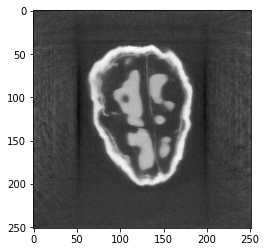

In [37]:
plt.imshow(vol_rec[:, 180, :], cmap='gray')

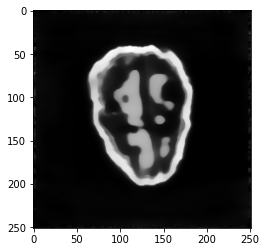

In [58]:
plt.imshow(vol_rec[:, 180, :], cmap='gray')

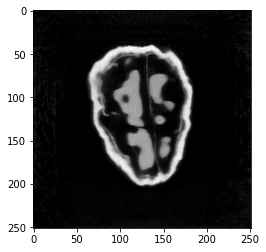

In [54]:
plt.imshow(vol_rec[:, 180, :], cmap='gray')

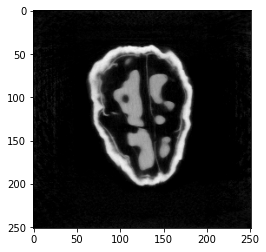

In [51]:
plt.imshow(vol_rec[:, 180, :], cmap='gray')

In [29]:
print(vol_rec.shape)

(251, 251, 251)


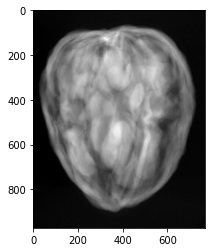

In [16]:
#index = random.randint(0, 359)
plt.imshow(p[:, index, :], cmap='gray')

In [57]:
# Reconstruction Algorithm Code Step by Step

from numba import jit
from numba import njit, prange

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)

@njit(parallel=True)
def G_Huber_prior_sart(estbuf, delta):
    priorbuf = np.zeros(estbuf.shape)
    cent     = 1
    
    for ind_x in prange(3, estbuf.shape[0]-3):
        for ind_y in prange(3, estbuf.shape[1]-3):
            for ind_z in prange(3, estbuf.shape[2]-3):
                # For All the Voxels
                
                for ind_nr_z  in range(ind_z-1, ind_z+2):
                    for ind_nr_y in range(ind_y-1, ind_y+2):
                        for ind_nr_x in range(ind_x-1, ind_x+2):
                            distance = np.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                            
                            if (distance == 0.0):
                                distance = 1.0
                            
                            #if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                            #    ind_nr = int(ind_voxel)
                            #else:
                            #    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                            
                            diff        = estbuf[ind_x][ind_y][ind_z] - estbuf[ind_nr_x][ind_nr_y][ind_nr_z]
                            denominator = np.sqrt(1.0+(diff/delta)*(diff/delta))
                            #priorbuf[ind_voxel] = priorbuf[ind_voxel] + diff
                            priorbuf[ind_x][ind_y][ind_z] = priorbuf[ind_x][ind_y][ind_z] + (1.0/distance)*diff/denominator
    return priorbuf

proj_id      = astra.data3d.link('-sino', proj_geom, projs)
proj_arr     = astra.data3d.get_shared(proj_id)#.flatten()

vol_rec      = np.zeros(vol_sz, dtype=np.float32)
only_ones_v  = np.ones(vol_rec.shape, dtype='float32')
only_ones_p  = np.ones(proj_arr.shape, dtype='float32')

delta = 0.001
niter = 100
beta  = 0.1

for j in range(0, niter):
    print("Iteration ", j)
    
    prior     = G_Huber_prior_sart(vol_rec, delta)
    
    p         = W.FP(vol_rec)
    diff      = proj_arr - p
    
    cost = np.square(diff)
    print("Cost is ", np.sum(cost), prior.shape, vol_rec.shape)
    
    temp_R    = W.FP(only_ones_v)
    diff      = my_divide(diff, temp_R)
    
    temp_back = W.BP(diff)
    temp_C    = W.BP(only_ones_p)
    vol       = my_divide(temp_back, temp_C)
    vol       = np.nan_to_num(vol)
    
    #vol[vol == np.nan] = 0
    
    vol      = np.reshape(vol, vol_rec.shape)
    vol_rec  = vol_rec + vol- beta*prior
    vol_rec[vol_rec < 0] = 0
    #print(temp_R.shape, temp_back.shape, temp_C.shape, p.shape, proj_arr.shape)
    #p = np.reshape(p, [detCols, 25, detRows])
    #print(p.shape, temp_back.shape)

#vol[vol == np.nan] = 0

Iteration  0
Cost is  224978290.0 (251, 251, 251) (251, 251, 251)
Iteration  1
Cost is  38869796.0 (251, 251, 251) (251, 251, 251)
Iteration  2
Cost is  27368532.0 (251, 251, 251) (251, 251, 251)
Iteration  3
Cost is  20742786.0 (251, 251, 251) (251, 251, 251)
Iteration  4
Cost is  16475825.0 (251, 251, 251) (251, 251, 251)
Iteration  5
Cost is  13598473.0 (251, 251, 251) (251, 251, 251)
Iteration  6
Cost is  11599077.0 (251, 251, 251) (251, 251, 251)
Iteration  7
Cost is  10148471.0 (251, 251, 251) (251, 251, 251)
Iteration  8
Cost is  9047298.0 (251, 251, 251) (251, 251, 251)
Iteration  9
Cost is  8174944.0 (251, 251, 251) (251, 251, 251)
Iteration  10
Cost is  7462295.5 (251, 251, 251) (251, 251, 251)
Iteration  11
Cost is  6863706.0 (251, 251, 251) (251, 251, 251)
Iteration  12
Cost is  6351973.0 (251, 251, 251) (251, 251, 251)
Iteration  13
Cost is  5906296.0 (251, 251, 251) (251, 251, 251)
Iteration  14
Cost is  5514723.0 (251, 251, 251) (251, 251, 251)
Iteration  15
Cost is  516

In [ ]:
# run FDK algorithm
astra.algorithm.run(alg_id, 1)

# release memory allocated by ASTRA structures
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)

print(np.round_(time.time() - t, 3), 'sec elapsed')



### save reconstruction ########################################################

t = time.time();
print('save results', flush=True)

# low level plotting
f, ax = plt.subplots(1, 3, sharex=False, sharey=False)
ax[0].imshow(vol_rec[vol_sz[0]//2,:,:])
ax[1].imshow(vol_rec[:,vol_sz[1]//2,:])
ax[2].imshow(vol_rec[:,:,vol_sz[2]//2])
f.tight_layout()

# construct full path for storing the results
recon_path_full = os.path.join(recon_path, 'Walnut{}'.format(walnut_id))

# create the directory in case it doesn't exist yet
if not os.path.exists(recon_path_full):
    os.makedirs(recon_path_full)

# Save every slice in  the volume as a separate tiff file
for i in range(vol_sz[0]):
    slice_path = os.path.join(recon_path_full, 'fdk_pos{}_ass{}_vmm{}_{:06}.tiff'.format(orbit_id,
                                  angluar_sub_sampling, voxel_per_mm, i))
    imageio.imwrite(slice_path, vol_rec[i,...])

print(np.round_(time.time() - t, 3), 'sec elapsed')


load and pre-process data


/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:2945: UserWarning: invalid tag value offset
  warnings.warn(str(e))


54.49 sec elapsed
compute reconstruction:
running power iteration to determine step size
plugin initialized.
running 50 iterations of Accelerated Gradient plugin.
iteration 0 / 50
iteration 10 / 50
iteration 20 / 50
iteration 30 / 50
iteration 40 / 50
119.815 sec elapsed
save results
0.813 sec elapsed


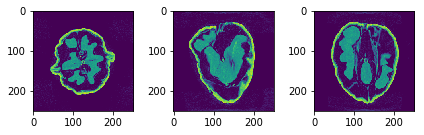

In [ ]:
for k in range(360):
    p     = projs[:, k, :]
    #noise = random_noise(p, mode="poisson")
    #noise = np.random.poisson(p)
    #noise = np.random.normal(0, 0.1, p.shape)
    p     = p + noise
    projs[:, k, :] = p
projs = np.ascontiguousarray(projs)

In [47]:
import SimpleITK as sitk

a1 = sitk.GetImageFromArray(vol_rec)
sitk.WriteImage(a1, 'test2.nii.gz')

In [40]:
#print(vol_rec.shape)

(251, 251, 251)


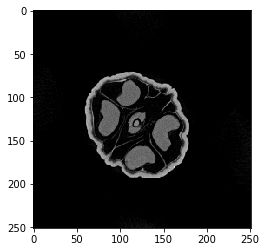

In [38]:
plt.imshow(vol_rec[170], cmap='gray')

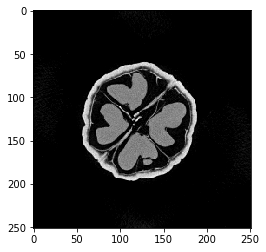

In [37]:
plt.imshow(vol_rec[70], cmap='gray')

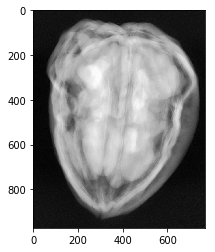

In [17]:
#print(projs.shape)
#t1 = copy.deepcopy(projs[:, 180, :])

plt.imshow(projs[:, 180, :], cmap='gray')